In [488]:
%run DL_func.ipynb

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [489]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [490]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Z3,Y,Env_mean,Env,c
0,2.56,2.28,1.99,3.22,0.2,0,red
1,6.66,13.19,18.54,19.60,5.0,3,yellow
2,1.24,-2.92,-1.98,-2.04,0.2,0,red
3,3.05,4.10,6.55,6.46,2.0,1,blue
4,2.99,2.42,7.24,5.98,2.0,1,blue
...,...,...,...,...,...,...,...
3995,4.97,9.36,14.74,14.43,5.0,3,yellow
3996,3.93,8.56,10.56,10.94,5.0,3,yellow
3997,1.43,-0.87,1.30,-0.45,0.2,0,red
3998,2.17,3.93,5.53,5.77,2.0,1,blue


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

C:\Users\mathi\AppData\Local\Temp/ipykernel_7540/3887001011.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


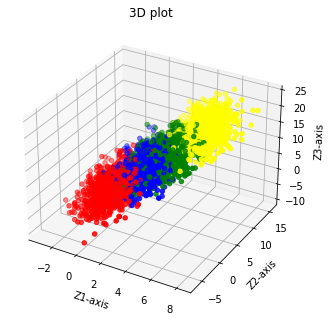

In [491]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [492]:
net=Net1(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [493]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [494]:
z_dim=3
net=UglyVAE(x.float(), y.float(), e.float(), 15, z_dim, z_dim, 10, 5, z_dim, beta=1)

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [495]:
net.elbo(x.float(), y.float(), e.float())

tensor(-9458.2275, grad_fn=<MeanBackward0>)

In [496]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(214.3445)
Epoch 40 of 200
Train loss: tensor(74.7523)
Epoch 60 of 200
Train loss: tensor(39.8647)
Epoch 80 of 200
Train loss: tensor(22.4255)
Epoch 100 of 200
Train loss: tensor(13.6153)
Epoch 120 of 200
Train loss: tensor(8.1674)
Epoch 140 of 200
Train loss: tensor(4.7984)
Epoch 160 of 200
Train loss: tensor(2.9409)
Epoch 180 of 200
Train loss: tensor(1.8983)
Epoch 200 of 200
Train loss: tensor(1.2953)


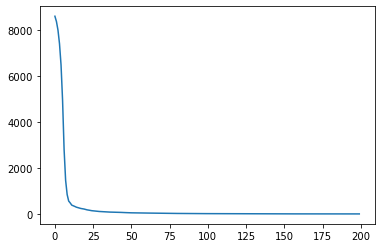

In [497]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [498]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    #_, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    zu, zsigma, de_u, z, prior_params = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [499]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [500]:
#%matplotlib qt
#plot_latent_3d(df, m)
#fig = plt.figure()


# creating the plot
#plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
#plt.title("3D plot")
#plt.xlabel('Z1-axis')
#plt.ylabel('Z2-axis')

In [501]:
pdf=df[['Z1', 'Z2', 'Z3']]
pdf.columns = ['pZ1', 'pZ2', 'pZ3']
cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values
cdf['pZ3']=pdf['pZ3'].values

corrs=cdf.corr().iloc[:3,3:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs
corrs

,pZ1,pZ2,pZ3
Z1,0.462557,0.828935,-0.850499
Z2,0.690289,0.871305,-0.959697
Z3,0.491305,0.977554,-0.994576


In [502]:
abscorrs=np.abs(corrs)

In [503]:
abscorrs

,pZ1,pZ2,pZ3
Z1,0.462557,0.828935,0.850499
Z2,0.690289,0.871305,0.959697
Z3,0.491305,0.977554,0.994576


In [504]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    from paper: 
    We also compute the mean correlation coefficient (MCC) used in Khemakhem et al. (2020a), which
    can be obtained by calculating the correlation coefficient between all pairs of true and recovered
    latent factors and then solving a linear sum assignment problem by assigning each recovered latent
    factor to the true latent factor with which it best correlates

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): _description_
    """
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted
    row_ind, col_ind = linear_sum_assignment(reduced_matrix, maximize=True)

    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]
    print(mcc)
    mcc = np.sum(mcc) / (num_predicted)
    return mcc

In [505]:
MCC(cdf.iloc[:,:3].values, pdf.values)

[0.8504994606204077, 0.6902894653774237, 0.9775544443136075]


0.839447790103813

In [506]:
pd.DataFrame(np.abs(np.corrcoef(cdf.iloc[:,:3].T.values, pdf.T.values))).iloc[:3,3:]

,3,4,5
0,0.462557,0.828935,0.850499
1,0.690289,0.871305,0.959697
2,0.491305,0.977554,0.994576


## Case with just 2 latent variables ##

In [507]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [508]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Y,Env_mean,Env,c
0,1.71,3.41,5.60,0.2,0,red
1,4.66,9.23,16.28,5.0,3,yellow
2,-0.76,1.62,1.31,0.2,0,red
3,0.42,2.16,2.84,0.2,0,red
4,1.93,3.68,7.60,2.0,1,blue
...,...,...,...,...,...,...
3995,0.71,1.32,0.42,0.2,0,red
3996,3.65,7.30,12.33,3.0,2,green
3997,2.60,4.45,5.82,3.0,2,green
3998,-0.95,1.83,1.40,0.2,0,red


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

In [509]:
# for creating a responsive plot
#%matplotlib qt

#plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [510]:
net=Net1(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [511]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [512]:
z_dim=2
net=UglyVAE(x.float(), y.float(), e.float(), 15, z_dim, z_dim, 10, 5, z_dim, beta=1)

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [513]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(42.9262)
Epoch 40 of 200
Train loss: tensor(4.9378)
Epoch 60 of 200
Train loss: tensor(2.0698)
Epoch 80 of 200
Train loss: tensor(0.5976)
Epoch 100 of 200
Train loss: tensor(-0.7514)
Epoch 120 of 200
Train loss: tensor(-2.0071)
Epoch 140 of 200
Train loss: tensor(-3.1728)
Epoch 160 of 200
Train loss: tensor(-4.1683)
Epoch 180 of 200
Train loss: tensor(-4.8758)
Epoch 200 of 200
Train loss: tensor(-5.8024)


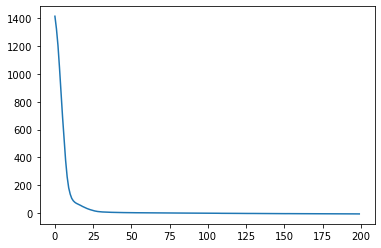

In [514]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [515]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    #_, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    zu, zsigma, de_u, z, prior_params = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [516]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [517]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

<Figure size 432x288 with 0 Axes>

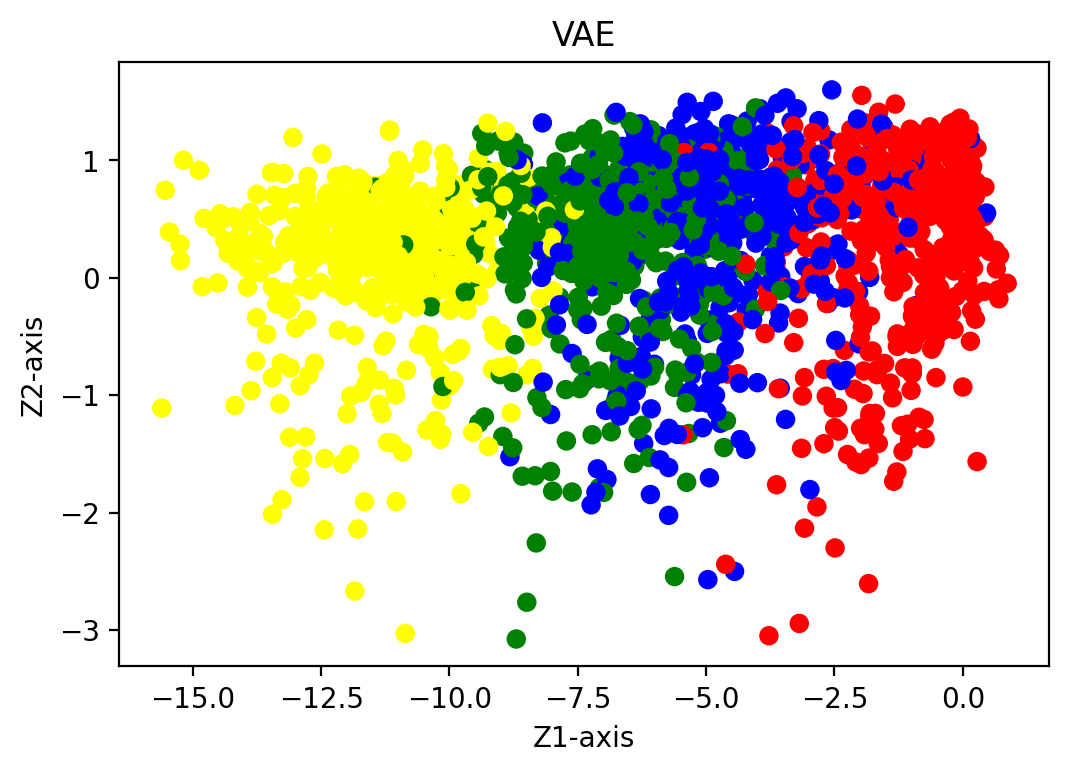

In [524]:
#%matplotlib qt
#plot_latent_3d(df, m)
%matplotlib inline
fig = plt.figure()

plt.figure(figsize=(6,4), dpi=200)
# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("VAE")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')
plt.savefig('VAE_2d.jpg')

In [519]:
pdf=df[['Z1', 'Z2']]
pdf.columns = ['pZ1', 'pZ2']
cdf=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values

corrs=cdf.corr().iloc[:2,2:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs

(-0.34708133435522914, 0.5728345500326445)

In [520]:
MCC(cdf.iloc[:,:2].values, pdf.values)

[0.341552296676267, 0.9199158843878743]


0.6307340905320706

In [521]:
pd.DataFrame(np.corrcoef(cdf.iloc[:,:2].values, pdf.values, rowvar=False))

,0,1,2,3
0,1.000000,0.752278,-0.938921,-0.341552
1,0.752278,1.000000,-0.919916,0.225753
2,-0.938921,-0.919916,1.000000,0.120017
3,-0.341552,0.225753,0.120017,1.000000


In [522]:
corrs

,pZ1,pZ2
Z1,-0.938921,-0.341552
Z2,-0.919916,0.225753
